In [180]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score, roc_curve, auc, log_loss
from sklearn import preprocessing
from sklearn import neighbors

from scipy import stats

import scikitplot as skplt

import statsmodels.api as sm
import statsmodels.formula.api as smf

from ipywidgets import widgets

%matplotlib inline
plt.style.use('seaborn-white')

# 4.1 An Overview of Classification

### Load data

In [2]:
# In R, I exported the dataset from package 'ISLR' to an Excel file
df_default = pd.read_excel('Data/Default.xlsx')

# Note: factorize() returns two objects: a label array and an array with the unique values.
# We are only interested in the first object. 
df_default['default2'] = df_default.default.factorize()[0]
df_default['student2'] = df_default.student.factorize()[0]
df_default.head(3)

,default,student,balance,income,default2,student2
1,No,No,729.526495,44361.625074,0,0
2,No,Yes,817.180407,12106.134700,0,1
3,No,No,1073.549164,31767.138947,0,0


### Plot data

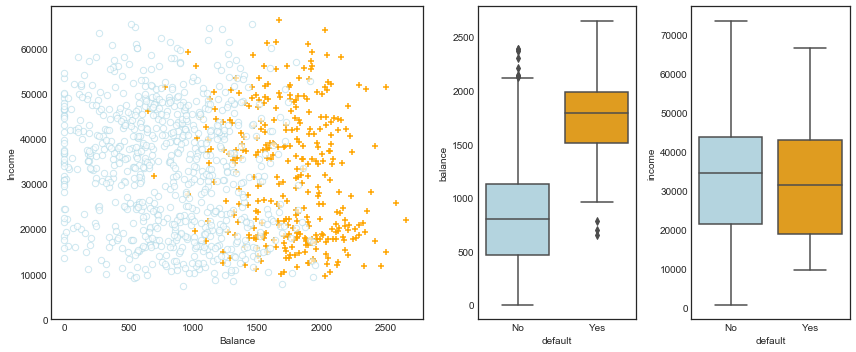

In [3]:
fig = plt.figure(figsize=(12,5))
gs = mpl.gridspec.GridSpec(1, 4)
ax1 = plt.subplot(gs[0,:-2])
ax2 = plt.subplot(gs[0,-2])
ax3 = plt.subplot(gs[0,-1])

# Take a fraction of the samples where target value (default) is 'no'
df_no = df_default[df_default.default2 == 0].sample(frac=.08)
# Take all samples  where target value is 'yes'
df_yes = df_default[df_default.default2 == 1]

ax1.scatter(df_yes.balance, df_yes.income, s=40, c='orange', marker='+', linewidths=1)
ax1.scatter(df_no.balance, df_no.income, s=40, marker='o', linewidths='1',
            edgecolors='lightblue', facecolors='white', alpha=.6)

ax1.set_ylim(ymin=0)
ax1.set_ylabel('Income')
ax1.set_xlim(xmin=-100)
ax1.set_xlabel('Balance')

c_palette = {'No':'lightblue', 'Yes':'orange'}
sns.boxplot('default', 'balance', data=df_default, orient='v', ax=ax2, palette=c_palette)
sns.boxplot('default', 'income', data=df_default, orient='v', ax=ax3, palette=c_palette)
gs.tight_layout(plt.gcf())

# 4.3 Logistic regression

### scikit-learn

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)
classes:  [0 1]
coefficients:  [-10.651330005794106, 0.0054989165568046445]


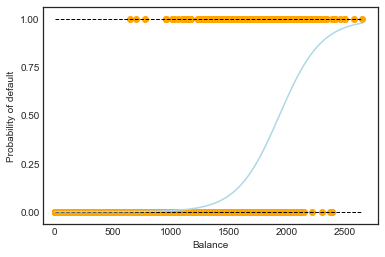

In [4]:
X_train = df_default.balance.values.reshape(-1,1) 
y = df_default.default2

# Create array of test data. Calculate the classification probability
# and predicted classification.
X_plot = np.arange(df_default.balance.min(), df_default.balance.max()).reshape(-1,1)

clf = skl_lm.LogisticRegression(solver='newton-cg')
clf.fit(X_train,y)
prob = clf.predict_proba(X_plot)

fig = plt.figure()
ax = plt.axes()
# Right plot
ax.scatter(X_train, y, color='orange')
ax.plot(X_plot, prob[:,1], color='lightblue')

ax.hlines(1, xmin=ax.xaxis.get_data_interval()[0],
              xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
ax.hlines(0, xmin=ax.xaxis.get_data_interval()[0],
              xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
ax.set_ylabel('Probability of default')
ax.set_xlabel('Balance')
ax.set_yticks([0, 0.25, 0.5, 0.75, 1.])
ax.set_xlim(xmin=-100)
print(clf)
print('classes: ', clf.classes_)
print('coefficients: ', [*clf.intercept_, *clf.coef_.tolist()[0]])

### statsmodels

In [5]:
X_train = sm.add_constant(df_default.balance)
y = df_default.default2
est = smf.Logit(y.ravel(), X_train).fit()
est.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.079823
         Iterations 10


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,-10.651331,0.361169,-29.491287,3.723665e-191,-11.359208,-9.943453
balance,0.005499,0.000220,24.952404,2.010855e-137,0.005067,0.005931


In [6]:
X_train = sm.add_constant(df_default.student2)
y = df_default.default2
est = smf.Logit(y, X_train).fit()
est.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.145434
         Iterations 7


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,-3.504128,0.070713,-49.554094,0.000000,-3.642723,-3.365532
student2,0.404887,0.115019,3.520177,0.000431,0.179454,0.630320


In [7]:
X_train = sm.add_constant(df_default[['balance', 'income', 'student2']])
est = smf.Logit(y, X_train).fit()
est.summary2()

Optimization terminated successfully.
         Current function value: 0.078577
         Iterations 10


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.462      
Dependent Variable: default2         AIC:              1579.5448  
Date:               2018-05-28 13:06 BIC:              1608.3862  
No. Observations:   10000            Log-Likelihood:   -785.77    
Df Model:           3                LL-Null:          -1460.3    
Df Residuals:       9996             LLR p-value:      3.2575e-292
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     10.0000                                       
-------------------------------------------------------------------
             Coef.    Std.Err.     z      P>|z|    [0.025    0.975]
-------------------------------------------------------------------
const       -10.8690    0.4923  -22.0793  0.0000  -11.8339  -9.9042
balance       0.0057    0.0002   24.7365  0.0000    0.0053   0.0062
income        0.0000    0.0000    0.3698  0.7115   -0.0000   0.0000
student2     -0.6468    0.2363   -2.7376  0.0062   -1.1098  -0.1837
==================================================================

"""

# 4.4 Linear Discriminant Analysis

In [175]:
def plot_classification(model, X_test, y_test):   
    fig = plt.figure(figsize=(8,8))
    ax = plt.subplot(1,1,1)
    
    data1 = X_test[y_test==1]
    data0 = X_test[y_test==0]
    
    # Data
    ax.scatter(data1.values[:,0], data1.values[:,1], s=20, c='red', marker='o', label='1')
    ax.scatter(data0.values[:,0], data0.values[:,1], s=20, c='blue', marker='o', label='1')
    ax.set_xlabel(data1.columns[0]);
    ax.set_ylabel(data1.columns[1]);
    
    maxX1, maxX2 = X_test.max()
    minX1, minX2 = X_test.min()
    N_points_grid = 200
    xx, yy = np.meshgrid(np.linspace(minX1, maxX1, N_points_grid), np.linspace(minX2, maxX2, N_points_grid))
    X = np.c_[xx.ravel(), yy.ravel()]
    est_region0 = model.predict(X) > 0
    est_region1 = np.logical_not(est_region0)

    # LDA regions
    plt.contourf(xx, yy, est_region1.reshape(xx.shape), alpha=0.5, colors='red', levels=[0.5, 1.0])
    plt.contourf(xx, yy, est_region0.reshape(xx.shape), alpha=0.5, colors='blue', levels=[0.5, 1.0]);

In [176]:
def generate_LDA(mean1=-2, mean2=1, mean3=2, sigma1=0.5, sigma2=0.5):
    mean1 = mean1*np.array([1, 1])
    mean2 = mean2*np.array([1, 1])
    mean3 = mean3*np.array([1, -1])
    cov = np.array([[sigma1, 0], [0, sigma2]])
    N = 500
    K = 3
    # if you sample from a t-distribution, the LDA results are really bad
    def multivariate_t(means, S, N):
        df = 1
        m = np.asarray(means)
        d = len(means)
        x = np.random.chisquare(df, N[0])/df
        z = np.random.multivariate_normal(np.zeros(d), S, N)
        return m + z/np.sqrt(x)[:,None]
    sample1 = np.random.multivariate_normal(mean1, cov, (N,)) 
    sample2 = np.random.multivariate_normal(mean2, cov, (N,)) 
    sample3 = np.random.multivariate_normal(mean3, cov, (N,))
    
    maxX = np.max([sample1[:,0], sample2[:,0], sample3[:,0]])
    minX = np.min([sample1[:,0], sample2[:,0], sample3[:,0]])
    maxY = np.max([sample1[:,1], sample2[:,1], sample3[:,1]])
    minY = np.min([sample1[:,1], sample2[:,1], sample3[:,1]])

    # priors
    pi1 = pi2 = pi3 = N/K

    # grid of points to plot the bayes and LDA regions/lines
    N_points_grid = 200
    xx, yy = np.meshgrid(np.linspace(minX, maxX, N_points_grid), np.linspace(minY, maxY, N_points_grid))
    X = np.c_[xx.ravel(), yy.ravel()]

    # Bayes regions
    inv_cov = np.linalg.inv(cov)
    delta1_fun = lambda X: np.dot(X, np.dot(inv_cov, mean1)) - 1/2*np.dot(mean1.T, np.dot(inv_cov, mean1)) + np.log(pi1)
    delta2_fun = lambda X: np.dot(X, np.dot(inv_cov, mean2)) - 1/2*np.dot(mean2.T, np.dot(inv_cov, mean2)) + np.log(pi2)
    delta3_fun = lambda X: np.dot(X, np.dot(inv_cov, mean3)) - 1/2*np.dot(mean3.T, np.dot(inv_cov, mean3)) + np.log(pi3)
    region1 = np.logical_and(delta1_fun(X) > delta2_fun(X), delta1_fun(X) > delta3_fun(X))
    region2 = np.logical_and(delta2_fun(X) > delta1_fun(X), delta2_fun(X) > delta3_fun(X))
    region3 = np.logical_and(delta3_fun(X) > delta1_fun(X), delta3_fun(X) > delta2_fun(X))

    # LDA prediction
    est_mean1 = 1/N*np.sum(sample1, axis=0)
    est_mean2 = 1/N*np.sum(sample2, axis=0)
    est_mean3 = 1/N*np.sum(sample3, axis=0)
    est_cov = (np.cov(sample1, rowvar=False) + np.cov(sample2, rowvar=False) + np.cov(sample3, rowvar=False))/K
    inv_est_cov = np.linalg.inv(est_cov)
    est_delta1_fun = lambda X: np.dot(X, np.dot(inv_est_cov, est_mean1)) - 1/2*np.dot(est_mean1.T, np.dot(inv_est_cov, est_mean1)) + np.log(pi1)
    est_delta2_fun = lambda X: np.dot(X, np.dot(inv_est_cov, est_mean2)) - 1/2*np.dot(est_mean2.T, np.dot(inv_est_cov, est_mean2)) + np.log(pi2)
    est_delta3_fun = lambda X: np.dot(X, np.dot(inv_est_cov, est_mean3)) - 1/2*np.dot(est_mean3.T, np.dot(inv_est_cov, est_mean3)) + np.log(pi3)
    est_region1 = np.logical_and(est_delta1_fun(X) > est_delta2_fun(X), est_delta1_fun(X) > est_delta3_fun(X))
    est_region3 = np.logical_and(est_delta3_fun(X) > est_delta2_fun(X), est_delta3_fun(X) > est_delta1_fun(X))

    ### Plot Bayes regions and LDA lines
    fig = plt.figure(figsize=(8,8))
    ax = plt.subplot(1,1,1)

    # Bayes regions
    plt.contourf(xx, yy, region1.reshape(xx.shape), alpha=0.5, colors='g', levels=[0.5, 1.0])
    plt.contourf(xx, yy, region2.reshape(xx.shape), alpha=0.5, colors='orange', levels=[0.5, 1.0])
    plt.contourf(xx, yy, region3.reshape(xx.shape), alpha=0.5, colors='b', levels=[0.5, 1.0])

    # Samples
    ax.scatter(sample1[:,0], sample1[:,1], s=20, c='green', marker='o', label='1')
    ax.scatter(sample2[:,0], sample2[:,1], s=20, c='orange', marker='o', label='2')
    ax.scatter(sample3[:,0], sample3[:,1], s=20, c='blue', marker='o', label='3')
    ax.set_xlabel('X1');
    ax.set_ylabel('X2');

    # LDA lines
    plt.contour(xx, yy, est_region1.reshape(xx.shape), alpha=0.5, colors='k')
    plt.contour(xx, yy, est_region3.reshape(xx.shape), alpha=0.5, colors='k');
    
    # statistics
    pred_green = sum([np.logical_and(delta1_fun(x) > delta2_fun(x), delta1_fun(x) > delta3_fun(x)) for x in sample1])/N*100
    pred_orange = sum([np.logical_and(delta2_fun(x) > delta1_fun(x), delta2_fun(x) > delta3_fun(x)) for x in sample2])/N*100
    pred_blue = sum([np.logical_and(delta3_fun(x) > delta2_fun(x), delta3_fun(x) > delta1_fun(x)) for x in sample3])/N*100
    print('Bayes accuracy: ', np.round(pred_green, 1), np.round(pred_orange, 1), np.round(pred_blue, 1))
    est_pred_green = sum([np.logical_and(est_delta1_fun(x) > est_delta2_fun(x), est_delta1_fun(x) > est_delta3_fun(x)) for x in sample1])/N*100
    est_pred_orange = sum([np.logical_and(est_delta2_fun(x) > est_delta1_fun(x), est_delta2_fun(x) > est_delta3_fun(x)) for x in sample2])/N*100
    est_pred_blue = sum([np.logical_and(est_delta3_fun(x) > est_delta2_fun(x), est_delta3_fun(x) > est_delta1_fun(x)) for x in sample3])/N*100
    print('LDA accuracy: ', np.round(est_pred_green, 1), np.round(est_pred_orange, 1), np.round(est_pred_blue, 1))

In [151]:
interactive_plot = widgets.interactive(generate_LDA, 
                 mean1=(-2,2,0.5), mean2=(-2,2,0.5), mean3=(-2,2,0.5),
                 sigma1=(0.1,5,0.1), sigma2=(0.1,5,0.1),
                 continuous_update=False);
output = interactive_plot.children[-1]
output.layout.height = '15cm'
interactive_plot

interactive(children=(FloatSlider(value=-2.0, description='mean1', max=2.0, min=-2.0, step=0.5), FloatSlider(v…

Default dataset

In [182]:
X = df_default[['balance', 'income', 'student2']].values
y = df_default.default2.values

lda = LinearDiscriminantAnalysis(solver='svd')
y_pred = lda.fit(X, y).predict(X)

df_ = pd.DataFrame({'True default status': y,
                    'Predicted default status': y_pred})
df_.replace(to_replace={0:'No', 1:'Yes'}, inplace=True)

df_.groupby(['Predicted default status', 'True default status']).size().unstack('True default status').T

Predicted default status,No,Yes
True default status,,
No,9645,22
Yes,254,79


In [183]:
print(classification_report(y, y_pred, target_names=['No', 'Yes'], digits=3))

             precision    recall  f1-score   support

         No      0.974     0.998     0.986      9667
        Yes      0.782     0.237     0.364       333

avg / total      0.968     0.972     0.965     10000



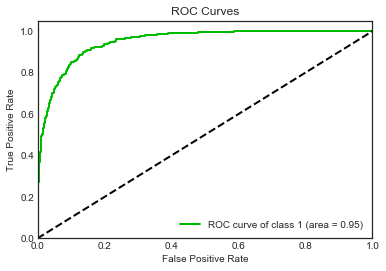

In [191]:
# ROC Curve
y_prob = lda.fit(X, y).predict_proba(X)
skplt.metrics.plot_roc(y, y_prob, plot_micro=False, plot_macro=False, classes_to_plot=[1]);

# 4.4.4 Quadratic Discriminant Analysis

In [155]:
def plot_QDA(mean1=-2, mean2=1, sigma1=1, sigma2=0.5):
    mean1 = mean1*np.array([1, 1])
    mean2 = mean2*np.array([1, 1])
    cov1 = np.array([[sigma1, 0], [0, sigma1]])
    cov2 = np.array([[sigma2, 0], [0, sigma2]])
    inv_cov1 = np.linalg.inv(cov1)
    inv_cov2 = np.linalg.inv(cov2)

    N = 500
    K = 2
    sample1 = np.random.multivariate_normal(mean1, cov1, (N,)) 
    sample2 = np.random.multivariate_normal(mean2, cov2, (N,)) 
    maxX = np.max([sample1[:,0], sample2[:,0]])
    minX = np.min([sample1[:,0], sample2[:,0]])
    maxY = np.max([sample1[:,1], sample2[:,1]])
    minY = np.min([sample1[:,1], sample2[:,1]])

    pi1 = pi2 = N/K

    # grid of points to plot the bayes and LDA regions/lines
    N_points_grid = 150
    xx, yy = np.meshgrid(np.linspace(minX, maxX, N_points_grid), np.linspace(minY, maxY, N_points_grid))
    X = np.c_[xx.ravel(), yy.ravel()]

    delta1_fun = lambda Xin: -1/2*((Xin-mean1).dot(inv_cov1)*(Xin-mean1)).sum(axis=1) + np.log(pi1)
    delta2_fun = lambda Xin: -1/2*((Xin-mean2).dot(inv_cov2)*(Xin-mean2)).sum(axis=1) + np.log(pi2)
    region1 = delta1_fun(X) > delta2_fun(X)
    region2 = delta2_fun(X) > delta1_fun(X)

    # prediction
    est_mean1 = 1/N*np.sum(sample1, axis=0)
    est_mean2 = 1/N*np.sum(sample2, axis=0)
    est_cov1 = np.cov(sample1, rowvar=False) 
    est_cov2 = np.cov(sample2, rowvar=False)
    inv_est_cov1 = np.linalg.inv(est_cov1)
    inv_est_cov2 = np.linalg.inv(est_cov2)
    est_delta1_fun = lambda Xin: -1/2*((Xin-est_mean1).dot(inv_est_cov1)*(Xin-est_mean1)).sum(axis=1) + np.log(pi1)
    est_delta2_fun = lambda Xin: -1/2*((Xin-est_mean2).dot(inv_est_cov2)*(Xin-est_mean2)).sum(axis=1) + np.log(pi2)
    est_region1 = est_delta1_fun(X) > est_delta2_fun(X)

    fig = plt.figure(figsize=(8,8))
    ax = plt.subplot(1,1,1)

    # Bayes regions
    plt.contourf(xx, yy, region1.reshape(xx.shape), alpha=0.5, colors='g', levels=[0.5, 1.0])
    plt.contourf(xx, yy, region2.reshape(xx.shape), alpha=0.5, colors='orange', levels=[0.5, 1.0])

    # Samples
    ax.scatter(sample1[:,0], sample1[:,1], s=20, c='green', marker='o',)
    ax.scatter(sample2[:,0], sample2[:,1], s=20, c='orange', marker='o',)
    ax.set_xlabel('X1');
    ax.set_ylabel('X2');

    # LDA lines
    plt.contour(xx, yy, est_region1.reshape(xx.shape), alpha=0.5, colors='k');
    
    pred_green = sum(delta1_fun(sample1) > delta2_fun(sample1))/N*100
    pred_orange = sum(delta2_fun(sample2) > delta1_fun(sample2))/N*100
    print('Bayes accuracy: ', np.round(pred_green, 1), np.round(pred_orange, 1))
    est_pred_green = sum(est_delta1_fun(sample1) > est_delta2_fun(sample1))/N*100
    est_pred_orange = sum(est_delta2_fun(sample2) > est_delta1_fun(sample2))/N*100
    print('LDA accuracy: ', np.round(est_pred_green, 1), np.round(est_pred_orange, 1))

In [156]:
interactive_plot = widgets.interactive(plot_QDA, 
                                 mean1=(-2,2,0.5), mean2=(-2,2,0.5),
                                 sigma1=(0.1,5,0.1), sigma2=(0.1,5,0.1),
                                 continuous_update=False);
output = interactive_plot.children[-1]
output.layout.height = '15cm'
interactive_plot

interactive(children=(FloatSlider(value=-2.0, description='mean1', max=2.0, min=-2.0, step=0.5), FloatSlider(v…

# 4.5 A Comparison of Classification Methods

Compare Logistic regression, LDA, QDA and KNN under different conditions

# 4.6 Lab: Stock Market data
## Analysis with Logistic Regression, LDA, QDA, and KNN

In [157]:
df_stock = pd.read_csv('Data/Smarket.csv', usecols=range(1,10), index_col=0, parse_dates=True)
# convert direction to binary. Up is 1, Down is 0
df_stock.replace({'Up': 1, 'Down': 0}, inplace=True)
df_stock.head()

,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
Year,,,,,,,,
2001-01-01,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,1
2001-01-01,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,1
2001-01-01,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,0
2001-01-01,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,1
2001-01-01,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,1


In [158]:
df_stock.describe()

,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
count,1250.000000,1250.000000,1250.000000,1250.000000,1250.00000,1250.000000,1250.000000,1250.000000
mean,0.003834,0.003919,0.001716,0.001636,0.00561,1.478305,0.003138,0.518400
std,1.136299,1.136280,1.138703,1.138774,1.14755,0.360357,1.136334,0.499861
min,-4.922000,-4.922000,-4.922000,-4.922000,-4.92200,0.356070,-4.922000,0.000000
25%,-0.639500,-0.639500,-0.640000,-0.640000,-0.64000,1.257400,-0.639500,0.000000
50%,0.039000,0.039000,0.038500,0.038500,0.03850,1.422950,0.038500,1.000000
75%,0.596750,0.596750,0.596750,0.596750,0.59700,1.641675,0.596750,1.000000
max,5.733000,5.733000,5.733000,5.733000,5.73300,3.152470,5.733000,1.000000


In [159]:
df_stock.corr()

,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
Lag1,1.000000,-0.026294,-0.010803,-0.002986,-0.005675,0.040910,-0.026155,-0.039757
Lag2,-0.026294,1.000000,-0.025897,-0.010854,-0.003558,-0.043383,-0.010250,-0.024081
Lag3,-0.010803,-0.025897,1.000000,-0.024051,-0.018808,-0.041824,-0.002448,0.006132
Lag4,-0.002986,-0.010854,-0.024051,1.000000,-0.027084,-0.048414,-0.006900,0.004215
Lag5,-0.005675,-0.003558,-0.018808,-0.027084,1.000000,-0.022002,-0.034860,0.005423
Volume,0.040910,-0.043383,-0.041824,-0.048414,-0.022002,1.000000,0.014592,0.022951
Today,-0.026155,-0.010250,-0.002448,-0.006900,-0.034860,0.014592,1.000000,0.730563
Direction,-0.039757,-0.024081,0.006132,0.004215,0.005423,0.022951,0.730563,1.000000


In [160]:
# very small correlations (today and direction are obiously correlated)
corr = df_stock.corr().values
np.max(np.abs(np.triu(corr, k=1)), axis=1)

array([0.04090991, 0.04338321, 0.04182369, 0.04841425, 0.03486008,
       0.02295096, 0.7305629 , 0.        ])

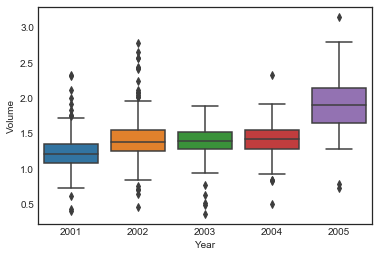

In [161]:
# volume increases with year
plot = sns.boxplot(df_stock.index, df_stock['Volume'],)
plot.set_xticklabels([str(date.year) for date in df_stock.index.unique()]);

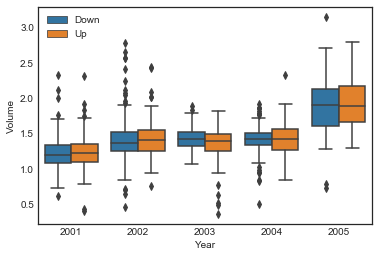

In [162]:
# volumne by year and direction
ax = sns.boxplot(df_stock.index, df_stock['Volume'], hue=df_stock['Direction'])
ax.set_xticklabels([str(date.year) for date in df_stock.index.unique()])
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ["Down", "Up"]);

In [340]:
# Helper functions to print classification diagnostics
def print_classification_statistics(model, X_test, y_test, labels=None):
    y_pred = model.predict(X_test)
    print('Classification Report:')
    print(classification_report(y_test, y_pred, target_names=labels, digits=3))
    cm = confusion_matrix(y_test, y_pred)
    cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cm, columns=pd.MultiIndex.from_product([['Predicted'],['True', 'False']]),
                         index=pd.MultiIndex.from_product([['Real'],['True', 'False']]))
    print('Confusion Matrix:')
    print(df_cm)
    print()
def plot_ROC(model, X_test, y_test, label=None):
    y_prob = model.predict_proba(X_test)
    ax = skplt.metrics.plot_roc(y_test, y_prob, plot_micro=False, plot_macro=False)
    ax.set_xlim([-0.01, 1.0])
    ax.set_ylim([0.0, 1.05])
    
    handles, labels = ax.get_legend_handles_labels()
    if len(labels) > 0:
        labels[0] = labels[0].replace('ROC curve of class 1', label)
    ax.legend(handles, labels, loc="lower right")
def print_OLS_error_table(model, X_train, y_train):
    params = np.append(model.intercept_, model.coef_)
    predictions = model.predict(X_train)

    newX = pd.DataFrame({"Constant": np.ones(len(X_train))}).join(pd.DataFrame(X_train.values))
    
    if isinstance(model, skl_lm.LinearRegression):
        # for linear regression:
        MSE = (sum((y_train-predictions)**2))/(len(newX)-len(newX.columns))
        var_b = MSE*(np.linalg.inv(np.dot(newX.T, newX)).diagonal())
    elif isinstance(model, skl_lm.LogisticRegression):
        # for logistic regression:
        pred_prob = model.predict_proba(X_train)
        W = np.diagflat(pred_prob[:, 1]*(1-pred_prob[:, 1]))
        cov = np.dot(newX.T, np.dot(W, newX))
        var_b = np.linalg.inv(cov).diagonal()
        
    std_errs = np.sqrt(var_b)
    t_values = params/std_errs
    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in t_values]

    std_errs = np.round(std_errs,3)
    t_values = np.round(t_values,3)
    p_values = np.round(p_values,3)
    params = np.round(params,4)
    
    # log likelihood and AIC
    y_pred = logistic.predict_proba(X)
    LLK = -log_loss(y, y_pred, normalize=False) 
    df_model = len(*model.coef_)
    aic = 2*(df_model+1) - 2*LLK

    model_stats = pd.DataFrame(np.array([params, std_errs, t_values, p_values]).T, 
                               index=['Intercept', *X_train.columns], 
                               columns=['Coefficients', 'Standard Errors', 't values', 'p values'])
    
    print(f'No. Observations: {len(y_train)}')
    print(f'Df Residuals: {len(y_train)-df_model-1}')
    print(f'Df Model: {df_model}')
    print(f'Log-Likelihood: {LLK:.2f}')
    print(f'AIC: {aic:.2f}')
    print(model_stats)
    print()

## Data

In [341]:
X = df_stock[df_stock.columns.difference(['Today', 'Direction'])]
y = df_stock['Direction']
X_train = X[:'2004']
y_train = y[:'2004']
X_test = X['2005':]
y_test = y['2005':]

## 4.6.2 Logistic regression

### Logistic regression, not test/train split

No. Observations: 1250
Df Residuals: 1243
Df Model: 6
Log-Likelihood: -863.79
AIC: 1741.58
           Coefficients  Standard Errors  t values  p values
Intercept       -0.1259            0.241    -0.523     0.601
Lag1            -0.0731            0.050    -1.457     0.145
Lag2            -0.0423            0.050    -0.845     0.399
Lag3             0.0111            0.050     0.222     0.824
Lag4             0.0094            0.050     0.187     0.851
Lag5             0.0103            0.050     0.208     0.835
Volume           0.1354            0.158     0.855     0.393

Classification Report:
             precision    recall  f1-score   support

       Down      0.507     0.241     0.327       602
         Up      0.526     0.782     0.629       648

avg / total      0.517     0.522     0.483      1250

Confusion Matrix:
           Predicted          
                True     False
Real True   0.240864  0.759136
     False  0.217593  0.782407



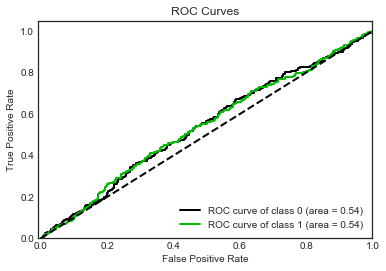

In [342]:
logistic = skl_lm.LogisticRegression(C=1e10)
logistic.fit(X, y)
print_OLS_error_table(logistic, X, y)
print_classification_statistics(logistic, X, y, labels=['Down', 'Up'])
plot_ROC(logistic, X, y, label='Logistic Classification')

# same results as statsmodels
#smLogistic = sm.Logit(y, sm.add_constant(X)).fit()
#print(smLogistic.summary())

### Logistic regression, with test/train split

No. Observations: 998
Df Residuals: 991
Df Model: 6
Log-Likelihood: -863.79
AIC: 1741.58
           Coefficients  Standard Errors  t values  p values
Intercept        0.1912            0.334     0.573     0.567
Lag1            -0.0542            0.052    -1.046     0.296
Lag2            -0.0458            0.052    -0.884     0.377
Lag3             0.0072            0.052     0.139     0.889
Lag4             0.0064            0.052     0.125     0.901
Lag5            -0.0042            0.051    -0.083     0.934
Volume          -0.1162            0.240    -0.485     0.628

Classification Report:
             precision    recall  f1-score   support

       Down      0.443     0.694     0.540       111
         Up      0.564     0.312     0.402       141

avg / total      0.511     0.480     0.463       252

Confusion Matrix:
           Predicted          
                True     False
Real True   0.693694  0.306306
     False  0.687943  0.312057



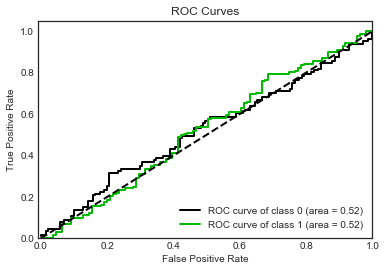

In [343]:
logistic_test = skl_lm.LogisticRegression(C=1e10)
logistic_test.fit(X_train, y_train)
print_OLS_error_table(logistic_test, X_train, y_train)
print_classification_statistics(logistic_test, X_test, y_test, labels=['Down', 'Up'])
plot_ROC(logistic_test, X_test, y_test, label='Logistic Classification Train/Test')

## 4.6.3 Linear Discriminant Analysis (LDA)

In [344]:
# use only Lag1 and Lag2
X_train2 = X_train[['Lag1','Lag2']]
X_test2 = X_test[['Lag1','Lag2']]

In [345]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train2, y_train)
print('Prior probabilities of groups: ')
print(pd.DataFrame(data=lda.priors_.reshape((1,2)), columns=['Down', 'Up'], index=['']))
print()
print('Group means: ')
print(pd.DataFrame(data=lda.means_, columns=X_train2.columns, index=['Down', 'Up']))
print()
print('Coefficients of linear discriminant: ')
print(pd.DataFrame(data=lda.scalings_, columns=['LDA'], index=X_train2.columns))
print()

Prior probabilities of groups: 
      Down        Up
  0.491984  0.508016

Group means: 
          Lag1      Lag2
Down  0.042790  0.033894
Up   -0.039546 -0.031325

Coefficients of linear discriminant: 
           LDA
Lag1 -0.642019
Lag2 -0.513529



Classification Report:
             precision    recall  f1-score   support

       Down      0.500     0.315     0.387       111
         Up      0.582     0.752     0.656       141

avg / total      0.546     0.560     0.538       252

Confusion Matrix:
           Predicted          
                True     False
Real True   0.315315  0.684685
     False  0.248227  0.751773



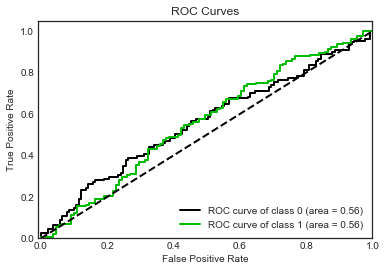

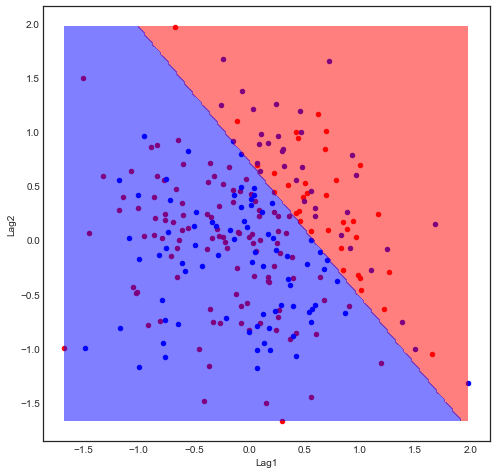

In [346]:
print_classification_statistics(lda, X_test2, y_test, labels=['Down', 'Up'])
plot_ROC(lda, X_test2, y_test, label='LDA Train/Test, only Lag1 and Lag2')
plot_classification(lda, X_test2, y_test)

## 4.6.4 Quadratic Discriminant Analysis (LDA)

In [349]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train2, y_train)
print('Prior probabilities of groups: ')
print(pd.DataFrame(data=qda.priors_.reshape((1,2)), columns=['Down', 'Up'], index=['']))
print()
print('Group means: ')
print(pd.DataFrame(data=qda.means_, columns=X_train2.columns, index=['Down', 'Up']))
print()

Prior probabilities of groups: 
      Down        Up
  0.491984  0.508016

Group means: 
          Lag1      Lag2
Down  0.042790  0.033894
Up   -0.039546 -0.031325



Classification Report:
             precision    recall  f1-score   support

       Down      0.600     0.270     0.373       111
         Up      0.599     0.858     0.706       141

avg / total      0.599     0.599     0.559       252

Confusion Matrix:
           Predicted          
                True     False
Real True   0.270270  0.729730
     False  0.141844  0.858156



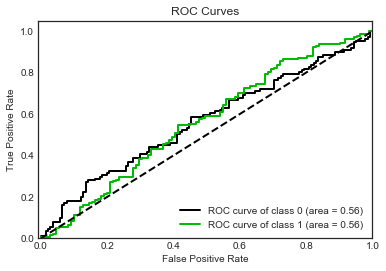

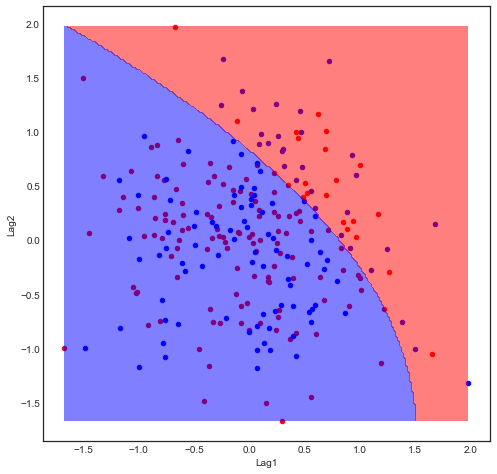

In [350]:
print_classification_statistics(qda, X_test2, y_test, labels=['Down', 'Up'])
plot_ROC(qda, X_test2, y_test, label='QDA Train/Test, only Lag1 and Lag2')
plot_classification(qda, X_test2, y_test)

## 4.6.5 K-Nearest Neighbors

In [351]:
n_neighbors = 3
knn = neighbors.KNeighborsClassifier(n_neighbors)
knn.fit(X_train2, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

Classification Report:
             precision    recall  f1-score   support

       Down      0.466     0.432     0.449       111
         Up      0.577     0.610     0.593       141

avg / total      0.528     0.532     0.529       252

Confusion Matrix:
           Predicted          
                True     False
Real True   0.432432  0.567568
     False  0.390071  0.609929



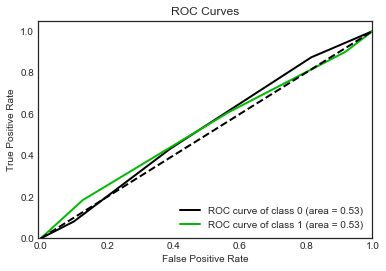

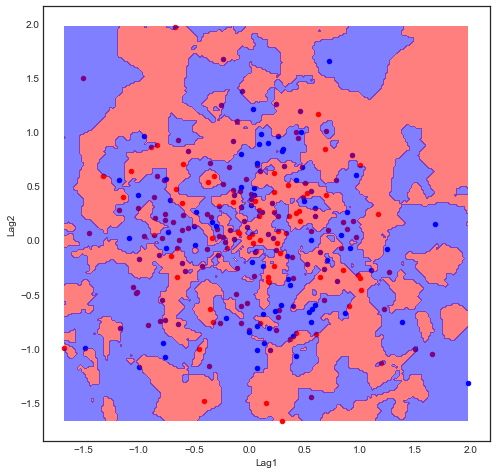

In [352]:
print_classification_statistics(knn, X_test2, y_test, labels=['Down', 'Up'])
plot_ROC(knn, X_test2, y_test, label='KNN Train/Test, only Lag1 and Lag2')
plot_classification(knn, X_test2, y_test)

## 4.6.6 An Application to Caravan Insurance Data

### KNN

In [375]:
df_caravan = pd.read_csv('Data/Caravan.csv')
df_caravan['Purchase'] = df_caravan['Purchase'].astype('category')
df_caravan.head()

,Unnamed: 0,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,Purchase
0,1,33,1,3,2,8,0,5,1,3,...,0,0,0,1,0,0,0,0,0,No
1,2,37,1,2,2,8,1,4,1,4,...,0,0,0,1,0,0,0,0,0,No
2,3,37,1,2,2,8,0,4,2,4,...,0,0,0,1,0,0,0,0,0,No
3,4,9,1,3,3,3,2,3,2,4,...,0,0,0,1,0,0,0,0,0,No
4,5,40,1,4,2,10,1,4,1,4,...,0,0,0,1,0,0,0,0,0,No


In [376]:
df_caravan['Purchase'].value_counts()

No     5474
Yes     348
Name: Purchase, dtype: int64

In [377]:
y = df_caravan.Purchase
X = df_caravan.drop('Purchase', axis=1).astype('float64')
X_scaled = preprocessing.scale(X)

In [378]:
X_test = X_scaled[:1000]
y_test = y[:1000]
X_train = X_scaled[1000:]
y_train = y[1000:]

In [387]:
for i in [1, 3, 5]:
    print(f'Using {i} neighbors')
    knn = neighbors.KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    print_classification_statistics(knn, X_test, y_test, labels=['No', 'Yes'])
    #plot_ROC(knn, X_test, y_test, label='KNN')
    #skplt.metrics.plot_confusion_matrix(y_test, knn.predict(X_test), normalize=False)
    plt.show()

Using 1 neighbors
Classification Report:
             precision    recall  f1-score   support

         No      0.948     0.937     0.943       941
        Yes      0.157     0.186     0.171        59

avg / total      0.902     0.893     0.897      1000

Confusion Matrix:
           Predicted          
                True     False
Real True   0.937301  0.062699
     False  0.813559  0.186441

Using 3 neighbors
Classification Report:
             precision    recall  f1-score   support

         No      0.946     0.979     0.962       941
        Yes      0.231     0.102     0.141        59

avg / total      0.903     0.927     0.913      1000

Confusion Matrix:
           Predicted          
                True     False
Real True   0.978746  0.021254
     False  0.898305  0.101695

Using 5 neighbors
Classification Report:
             precision    recall  f1-score   support

         No      0.944     0.993     0.968       941
        Yes      0.364     0.068     0.114        59



### Logistic

In [389]:
logistic = skl_lm.LogisticRegression(C=1e10)
logistic.fit(X_train, y_train)
print_classification_statistics(logistic, X_test, y_test, labels=['No', 'Yes'])

Classification Report:
             precision    recall  f1-score   support

         No      0.941     0.994     0.966       941
        Yes      0.000     0.000     0.000        59

avg / total      0.885     0.935     0.909      1000

Confusion Matrix:
           Predicted          
                True     False
Real True   0.993624  0.006376
     False  1.000000  0.000000



In [392]:
# using 25% changes of buying instead of 50%
pred_p = logistic.predict_proba(X_test)
cm_df = pd.DataFrame({'True': y_test, 'Pred': pred_p[:,1] > .25})
cm_df.Pred.replace(to_replace={True:'Yes', False:'No'}, inplace=True)
print(classification_report(y_test, cm_df.Pred))
print(cm_df.groupby(['True', 'Pred']).size().unstack('True').T)

             precision    recall  f1-score   support

         No       0.95      0.98      0.96       941
        Yes       0.34      0.19      0.24        59

avg / total       0.91      0.93      0.92      1000

Pred   No  Yes
True          
No    920   21
Yes    48   11
